In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
from notebook_utils import NotebookUtilities
import humanize

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(168528, 109)


In [4]:

# Patient accuracy rate (how many patients correct / number of patients treated)

# Initialize an empty list to store the dictionaries for each group
rows_list = []

# Iterate over the sessions grouped by scene
for (session_uuid, scene_index), scene_df in fu.get_session_groupby(extra_column='scene_index'):

    # Get the logger version
    logger_version = fu.get_logger_version(scene_df)
    
    # Initialize a dictionary to store the row data
    row_dict = {}
    for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
    row_dict['logger_version'] = logger_version

    # Get the total number of patients treated
    total_treated = fu.get_injury_treated_count(scene_df)

    # If there were any patients treated, calculate the accuracy rate
    if total_treated:

        # Filter the dataframe to only include rows where the injury was treated correctly
        correctly_treated = fu.get_injury_correctly_treated_count(scene_df)
        
        # Store data related to 'injury_treated' records in the dictionary
        row_dict['injury_treated_total_treated'] = total_treated
        row_dict['injury_treated_correctly_treated'] = correctly_treated

        # Calculate the accuracy rate and add the accuracy rate to the results dictionary
        row_dict['injury_treated_patient_accuracy_rate'] = correctly_treated / total_treated
    
    # Calculate patient accuracy rate for 'injury_record' records
    total_mask = (scene_df.injury_record_injury_treated == True)
    df2 = scene_df[total_mask]

    # Get the total number of injuries treated
    total_treated = df2.shape[0]

    # If there were any injuries treated, calculate the accuracy rate
    if total_treated:

        # Filter the dataframe to only include rows where the injury was treated correctly
        correct_mask = (df2.injury_record_injury_treated_with_wrong_treatment == False)
        correctly_treated = df2[correct_mask].shape[0]
        
        # Store data related to 'injury_record' records in the dictionary
        row_dict['injury_record_total_treated'] = total_treated
        row_dict['injury_record_correctly_treated'] = correctly_treated

        # Calculate the accuracy rate and add the accuracy rate to the results dictionary
        row_dict['injury_record_patient_accuracy_rate'] = correctly_treated / total_treated
    
    # Append the dictionary to the list of rows
    rows_list.append(row_dict)

# Create a DataFrame from the list of dictionaries
patient_accuracy_rate_df = DataFrame(rows_list)

In [5]:

# Show a sort of treated injury accuracy
mask_series = patient_accuracy_rate_df.injury_treated_patient_accuracy_rate.isnull()
display(patient_accuracy_rate_df[~mask_series].logger_version.unique())
patient_accuracy_rate_df[~mask_series].sort_values(
    ['injury_treated_patient_accuracy_rate', 'injury_treated_total_treated'], ascending=[True, True]
)

array([1. , 1.3])

,logger_version,session_uuid,scene_index,injury_treated_total_treated,injury_treated_correctly_treated,injury_treated_patient_accuracy_rate
109,1.0,46294fe1-e286-4772-8f71-3335a69a8dd2,1,3.0,1.0,0.333333
12,1.0,06574b6f-ab02-432c-9a65-7b031218a270,9,4.0,2.0,0.500000
170,1.0,724fdf45-3165-43b8-b9ca-dc07102d2886,8,4.0,2.0,0.500000
367,1.0,db948ce1-783d-4dff-a1f8-2be49570f327,1,4.0,2.0,0.500000
398,1.0,e9632b3b-77f2-4f62-a778-5d6a4242aa3b,1,4.0,2.0,0.500000
...,...,...,...,...,...,...
387,1.0,e3c2b4c6-d8b7-4b64-8cd0-7ca0e622f9b5,2,9.0,9.0,1.000000
395,1.0,e8cb6ae0-6d68-410f-88fc-4adf30d8bfac,2,9.0,9.0,1.000000
412,1.0,efed5e1c-4427-47df-8e3f-9e4714880169,2,9.0,9.0,1.000000
415,1.0,f0a4acff-b70a-4577-a27e-df492cb9638d,2,9.0,9.0,1.000000


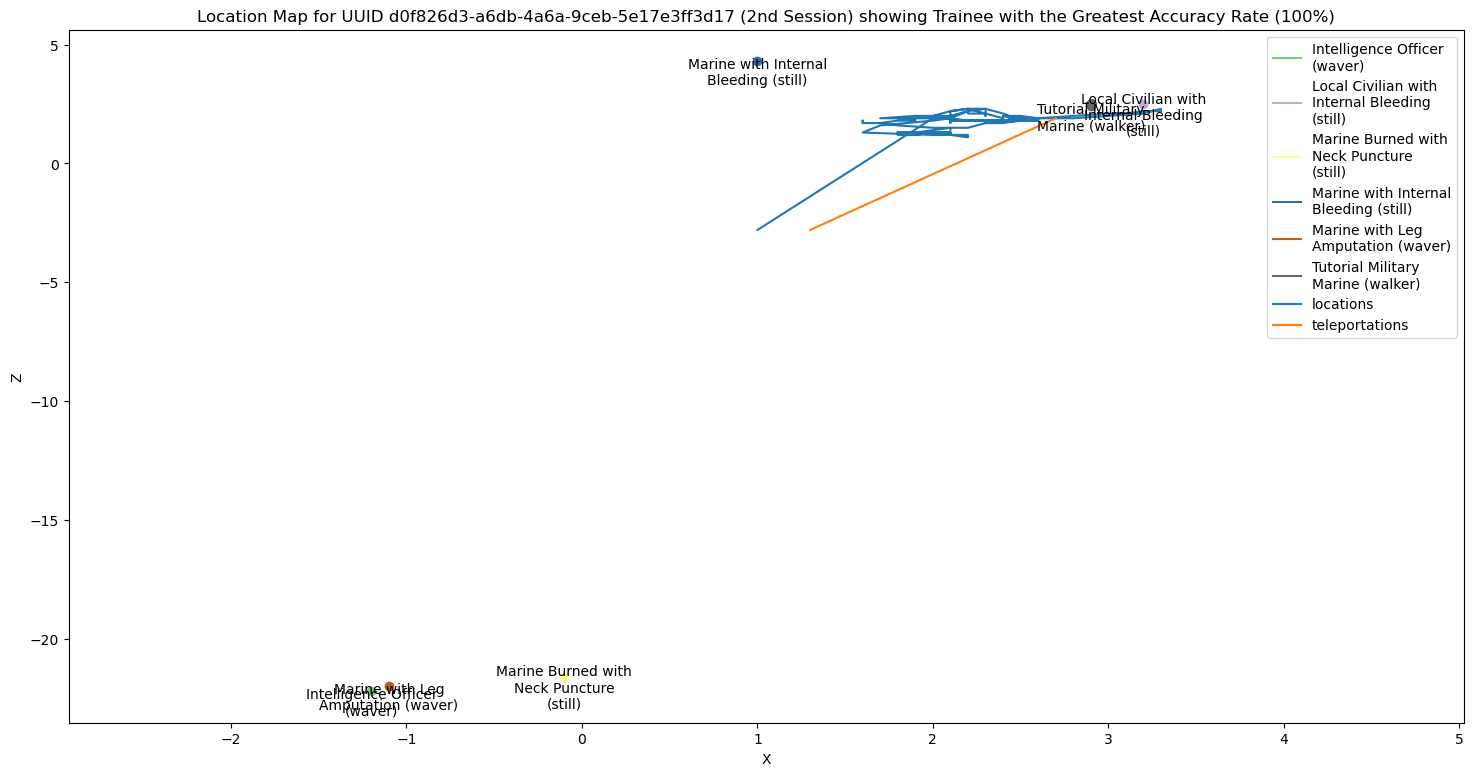

In [6]:

# Get scene with the greatest accuracy rate, v1.3

# Create a mask to filter rows with logger_version equal to 1.3
mask_series = (patient_accuracy_rate_df.logger_version == 1.3)

# Combine the mask with another mask to exclude rows with null accuracy rates
mask_series &= ~patient_accuracy_rate_df.injury_treated_patient_accuracy_rate.isnull()

# Filter the DataFrame based on the combined mask and sort it
df = patient_accuracy_rate_df[mask_series].sort_values(
    ['injury_treated_patient_accuracy_rate', 'injury_treated_total_treated'], ascending=[True, True]
).tail(1)

# Check if there is at least one row in the filtered DataFrame
if df.shape[0]:

    # Extract UUID and scene from the single-row DataFrame
    session_uuid = df.session_uuid.squeeze()
    scene_index = df.scene_index.squeeze()

    # Create a base mask to filter rows in the main DataFrame (frvrs_logs_df)
    base_mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_index == scene_index)
    
    # Create a title for visualization
    title = f'Location Map for UUID {session_uuid} ({humanize.ordinal(scene_index+1)} Session)'
    title += ' showing Trainee with the Greatest Accuracy Rate ('

    # Calculate and format the accuracy rate as a percentage
    patient_accuracy_rate = df.injury_treated_patient_accuracy_rate.min()
    title += humanize.intword(100 * patient_accuracy_rate, format='%d') + '%)'

    # Visualize the player movement for the scene with the greatest accuracy rate
    fu.visualize_player_movement(base_mask_series, title=title, frvrs_logs_df=frvrs_logs_df)

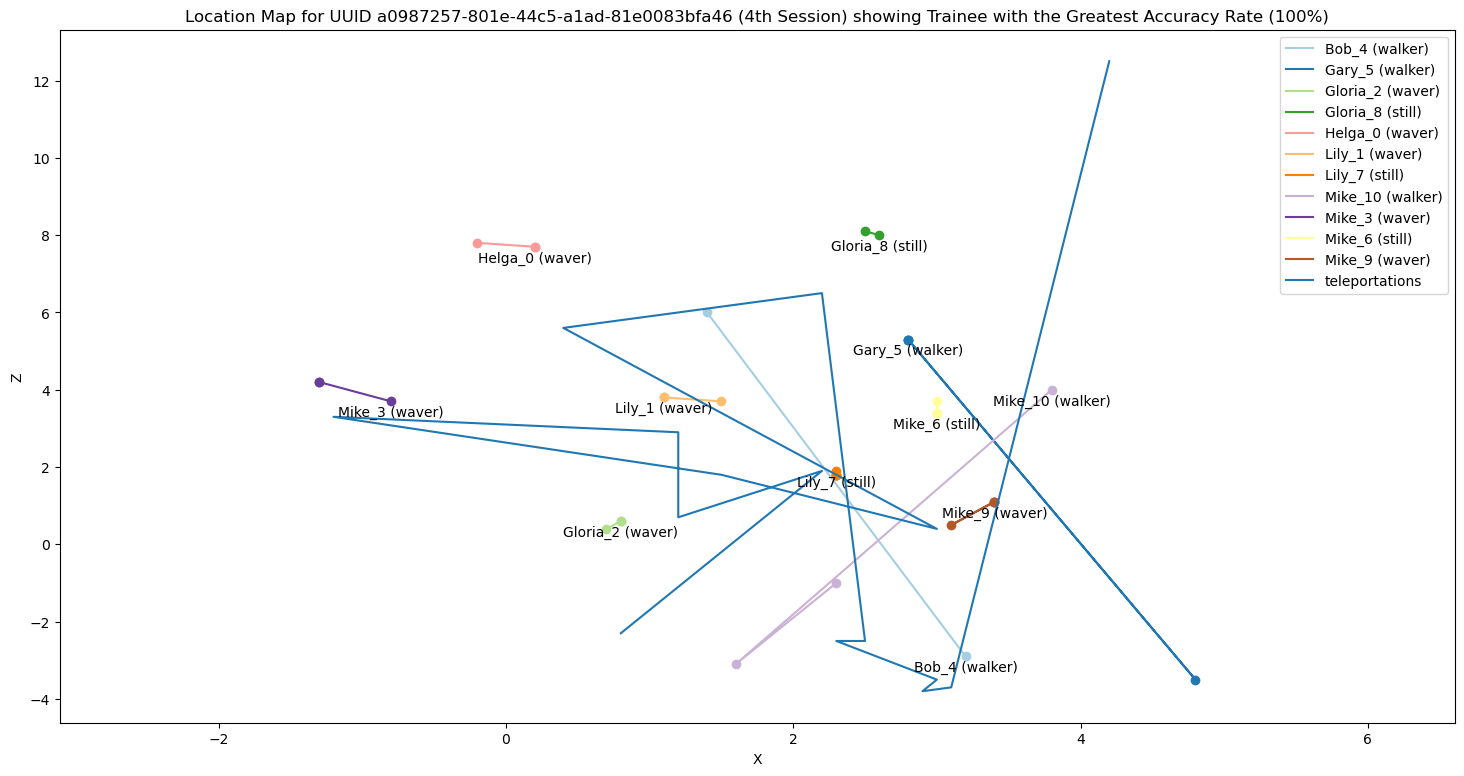

In [7]:

# Get scene with the greatest accuracy rate, v1.0
mask_series = (patient_accuracy_rate_df.logger_version == 1.0)
mask_series &= ~patient_accuracy_rate_df.injury_treated_patient_accuracy_rate.isnull()
df = patient_accuracy_rate_df[mask_series].sort_values(
    ['injury_treated_patient_accuracy_rate', 'injury_treated_correctly_treated'], ascending=[True, True]
).tail(1)
if df.shape[0]:
    session_uuid = df.session_uuid.squeeze()
    scene_index = df.scene_index.squeeze()
    base_mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_index == scene_index)
    
    title = f'Location Map for UUID {session_uuid} ({humanize.ordinal(scene_index+1)} Session)'
    title += ' showing Trainee with the Greatest Accuracy Rate ('
    patient_accuracy_rate = df.injury_treated_patient_accuracy_rate.min()
    title += humanize.intword(100 * patient_accuracy_rate, format='%d') + '%)'
    fu.visualize_player_movement(base_mask_series, title=title, frvrs_logs_df=frvrs_logs_df)

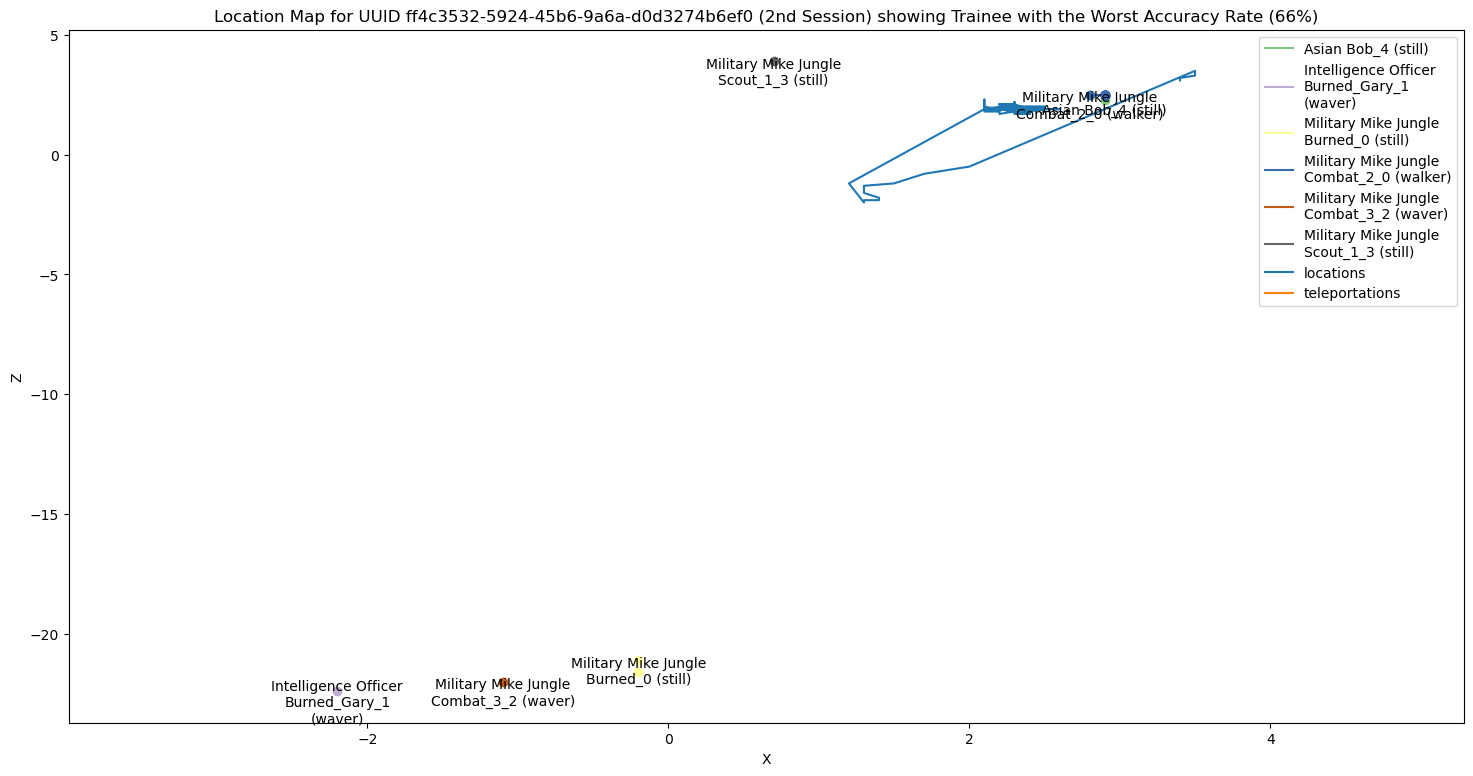

In [8]:

# Get scene with the worst accuracy rate, v1.3
mask_series = (patient_accuracy_rate_df.logger_version == 1.3)
mask_series &= ~patient_accuracy_rate_df.injury_treated_patient_accuracy_rate.isnull()
df = patient_accuracy_rate_df[mask_series].sort_values(
    ['injury_treated_patient_accuracy_rate', 'injury_treated_correctly_treated'], ascending=[True, False]
).head(1)
if df.shape[0]:
    session_uuid = df.session_uuid.squeeze()
    scene_index = df.scene_index.squeeze()
    base_mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_index == scene_index)
    
    title = f'Location Map for UUID {session_uuid} ({humanize.ordinal(scene_index+1)} Session)'
    title += ' showing Trainee with the Worst Accuracy Rate ('
    patient_accuracy_rate = df.injury_treated_patient_accuracy_rate.min()
    title += humanize.intword(100 * patient_accuracy_rate, format='%d') + '%)'
    fu.visualize_player_movement(base_mask_series, title=title, frvrs_logs_df=frvrs_logs_df)

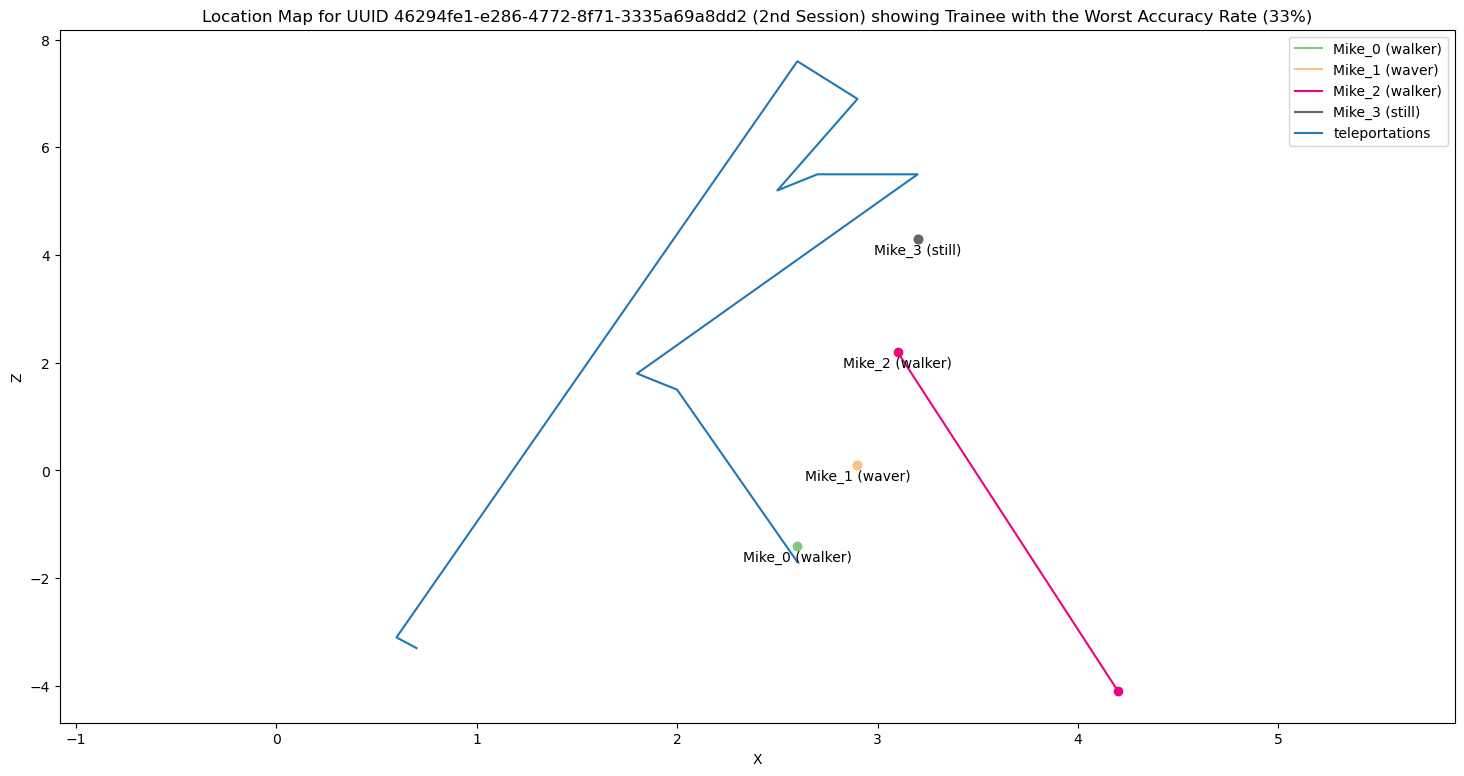

In [9]:

# Get scene with the worst accuracy rate, v1.0
mask_series = (patient_accuracy_rate_df.logger_version == 1.0)
mask_series &= ~patient_accuracy_rate_df.injury_treated_patient_accuracy_rate.isnull()
df = patient_accuracy_rate_df[mask_series].sort_values(
    ['injury_treated_patient_accuracy_rate', 'injury_treated_correctly_treated'], ascending=[True, False]
).head(1)
if df.shape[0]:
    session_uuid = df.session_uuid.squeeze()
    scene_index = df.scene_index.squeeze()
    base_mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_index == scene_index)
    
    title = f'Location Map for UUID {session_uuid} ({humanize.ordinal(scene_index+1)} Session)'
    title += ' showing Trainee with the Worst Accuracy Rate ('
    patient_accuracy_rate = df.injury_treated_patient_accuracy_rate.min()
    title += humanize.intword(100 * patient_accuracy_rate, format='%d') + '%)'
    fu.visualize_player_movement(base_mask_series, title=title, frvrs_logs_df=frvrs_logs_df)